In [49]:
from xgboost import XGBClassifier
import xgboost
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from numpy import mean
from sklearn.metrics import precision_recall_fscore_support
from matplotlib import pyplot
from sklearn import metrics

In [3]:
# read the data
X_train = pd.read_csv('../data/processed/X_train.csv',sep='|')
y_train = pd.read_csv('../data/processed/y_train.csv',sep='|')
X_test = pd.read_csv('../data/processed/X_test.csv',sep='|')
y_test = pd.read_csv('../data/processed/y_test.csv',sep='|')

In [4]:
# change object type to category for categorical columns
def convert_to_categorical_variables(data):
    categorical_columns = ['race', 'gender', 'admission_type_id',
        'admission_source_id', 'time_in_hospital', 'payer_code',
        'medical_specialty', 'diag_1',
        'diag_2', 'diag_3', 'metformin', 'repaglinide',
        'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
        'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
        'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
        'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
        'glipizide-metformin', 'glimepiride-pioglitazone',
        'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
        'diabetesMed']
    data[categorical_columns] = data[categorical_columns].astype("category")
    

In [5]:
convert_to_categorical_variables(X_train)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76324 entries, 0 to 76323
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      74600 non-null  category
 1   gender                    76324 non-null  category
 2   admission_type_id         76324 non-null  category
 3   admission_source_id       71270 non-null  category
 4   time_in_hospital          76324 non-null  category
 5   payer_code                76324 non-null  category
 6   medical_specialty         76324 non-null  category
 7   num_lab_procedures        76324 non-null  int64   
 8   num_procedures            76324 non-null  int64   
 9   num_medications           76324 non-null  int64   
 10  number_outpatient         76324 non-null  int64   
 11  number_emergency          76324 non-null  int64   
 12  diag_1                    76324 non-null  category
 13  diag_2                    76324 non-null  cate

In [6]:
convert_to_categorical_variables(X_test)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25442 entries, 0 to 25441
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      24893 non-null  category
 1   gender                    25442 non-null  category
 2   admission_type_id         25442 non-null  category
 3   admission_source_id       23715 non-null  category
 4   time_in_hospital          25442 non-null  category
 5   payer_code                25442 non-null  category
 6   medical_specialty         25442 non-null  category
 7   num_lab_procedures        25442 non-null  int64   
 8   num_procedures            25442 non-null  int64   
 9   num_medications           25442 non-null  int64   
 10  number_outpatient         25442 non-null  int64   
 11  number_emergency          25442 non-null  int64   
 12  diag_1                    25442 non-null  category
 13  diag_2                    25442 non-null  cate

The model performance is very low. I believe the data and the imbalance nature might be the main cause. To improve the model I would suggest:
- Gathering more data.
- Do resampling 
- If the problem performance is still low after the above, then consider modeling this problem using anomaly detection.
In the training code below, I used stratification to make sure the minority class is represented in every training split. 

In [9]:
# define model
xgb_model = XGBClassifier(enable_categorical=True)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
learning_rates =[0.05,0.1]
estimators=[100,500]
max_depths=[3,5,6]
alphas=[0,0.1]
weights = [1, 10, 50]
param_grid = dict(scale_pos_weight=weights,learning_rate=learning_rates,max_depth=max_depths,alpha=alphas,subsample=[0.8,1],seed=[27])
grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
grid.fit( X_train,y_train,)

# evaluate the best model
scores = cross_val_score(grid.best_estimator_, X_train,y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

# average performance
print('Mean ROC AUC: %.5f' % mean(scores))

/Users/imanalodah/Documents/ds_template/coding_interview_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mean ROC AUC: 0.60720


In [10]:
# Best parameters so far
grid.best_params_

{'alpha': 0.1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'scale_pos_weight': 1,
 'seed': 27,
 'subsample': 1}

[0.01919694 0.         0.01953707 0.02125694 0.03839275 0.02910183
 0.05065291 0.02090602 0.         0.09048106 0.04764775 0.14373636
 0.12311194 0.10191347 0.10391173 0.0259486  0.02799794 0.
 0.         0.         0.         0.         0.02329714 0.0006413
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02665744 0.         0.
 0.         0.         0.         0.         0.04547716 0.04013369]


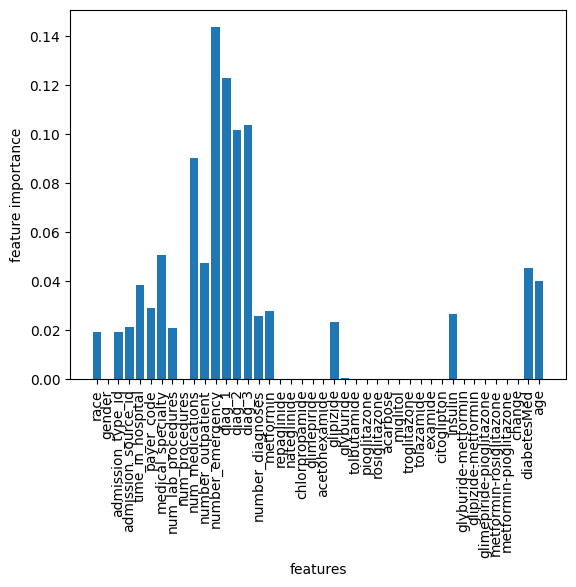

In [39]:
# get features importance
features_importance = pd.DataFrame(data =grid.best_estimator_.feature_importances_,index=X_train.columns, columns=['feature_importance'])
# plot
pyplot.bar(features_importance.index, grid.best_estimator_.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.xlabel("features")
pyplot.ylabel("feature importance")
pyplot.show()


In [40]:
features_importance

,feature_importance
race,0.019197
gender,0.000000
admission_type_id,0.019537
admission_source_id,0.021257
time_in_hospital,0.038393
payer_code,0.029102
medical_specialty,0.050653
num_lab_procedures,0.020906
num_procedures,0.000000
num_medications,0.090481


In [48]:
# checking the performance on the testset
y_pred = grid.best_estimator_.predict(X_test)
precision,recall,fscore,support= precision_recall_fscore_support(y_test, y_pred)
precision,recall,fscore,support 

(array([0.8884434, 0.5      ]),
 array([9.99955758e-01, 3.52236703e-04]),
 array([9.40907104e-01, 7.03977473e-04]),
 array([22603,  2839]))

In conclusion, the model didn't well perform at all on the test set. All the members where considered as negative class. I see two causes: the imbalance and the the data quality. If i am working on this with access to data, I would collect more data, do resampling, and try rare events modeling techniques.

In [70]:
# save the model
booster = grid.best_estimator_.get_booster()
booster.save_model('../models/booster_model.json')